In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import time 
import xgboost as xgb

In [2]:
def featureVector(Data, Abstract_heading, Title_heading, ngram):
    vectorizer = CountVectorizer(tokenizer=None, stop_words=None, ngram_range=ngram) #check the parameters for this once you have got it working
    vectorizer.fit(Data[Abstract_heading])
    Abstract_matrix = vectorizer.transform(Data[Abstract_heading]).toarray()
    vectorizer.fit(Data[Title_heading])
    Title_matrix = vectorizer.transform(Data[Title_heading]).toarray()
    matrix = np.concatenate((Abstract_matrix, Title_matrix), axis=1)
    features = vectorizer.get_feature_names()
    return matrix

In [3]:
def normalisedFeatureVector(feature_Vector, label_Vector):
    tf_Transformer = TfidfTransformer(use_idf=False).fit(feature_Vector)
    matrix = tf_Transformer.fit_transform(feature_Vector, label_Vector)    
    return matrix
    

In [139]:
a = mutual_info_classif(featureVector(Data.drop_duplicates(['URL']), Abstract_heading, Title_heading), label_Vector)

In [4]:
def filtered_feature_vector(feature_Vector, num_features, MI_list):
    sorted_ = np.argsort(MI_list)
    feature_index = []
    for i in range(0, num_features):
        feature_index.append(sorted_[sorted_.size-1-i,])
    print(feature_Vector.shape)
    print(feature_Vector[:,feature_index].shape)
    return feature_Vector[:, feature_index]

In [8]:
#Create mutual information score vectors
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
for i in range(0, len(Data)-1):
    if Data.loc[i, Label] == 'RCT':
        Data.set_value(i, Label, 'Y')
    else: 
        Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])
label_Vector = Data[Label].copy().as_matrix()
uni_gram_MI_vector = mutual_info_classif(featureVector(Data, Abstract_heading, Title_heading, (1,1)), label_Vector)
# bi_gram_MI_vector = mutual_info_classif(featureVector(Data, Abstract_heading, Title_heading, (1,2)), label_Vector)


/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [9]:
np.save('uni_gram_MI_vector', uni_gram_MI_vector) #####you need to save the unigram vector

N


/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[ 461    0]
 [1469    0]]


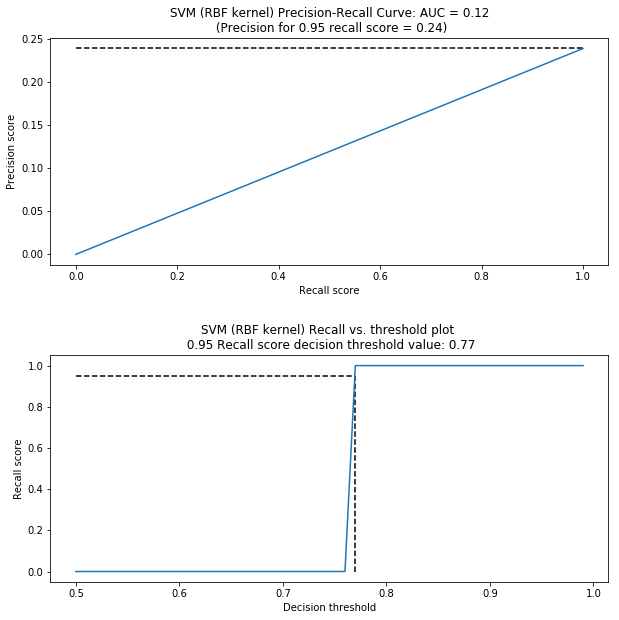

0.119430051813
5948.30448604


In [78]:
#Run model
start = time.time()
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
multiclass_model = False #Set to True if you want to build a multiclass classifier
normalised = False #Set to true if you want to normalise the feature vectore - Note that classifier trains faster
modelType = 'SVM' # NB - Naive bayes, SVM - support vector machine, Tree - Decision tree, 
#Gradient = Gradient boosting classifier, NN - Neural network, XG = XGBoost
feature_Selection = False #set to 'True' if you want to perform feature selection
ngram = (1,1) #tuple giving the range of ngrams considered
print(Data.loc[len(Data)-1, Label])
if multiclass_model == False: 
    for i in range(0, len(Data)-1):
        if Data.loc[i, Label] == 'RCT':
            Data.set_value(i, Label, 'Y')
        else: 
            Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])    
duplicates = Data.duplicated(['URL'])
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
feature_Vector = featureVector(Data, Abstract_heading, Title_heading, ngram)
label_Vector = Data[Label].copy().as_matrix()
if normalised: 
    feature_Vector = normalisedFeatureVector(feature_Vector, label_Vector)
if feature_Selection == True:
#     MI_list = mutual_info_classif(feature_Vector, label_Vector)
    print("MI complete!")
    feature_Vector = filtered_feature_vector(feature_Vector, 5000, MI_list)
if modelType == 'SVM':
    clf = svm.SVC(kernel='rbf', C=10.0, gamma = 1.0, probability = True)
    model= 'SVM (RBF kernel)'
if modelType == 'NB':
    clf = MultinomialNB()
    model='NB'
if modelType == 'Tree':
    clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=210)
    model = 'Decision Tree'   
if modelType == 'Gradient':
    clf = GradientBoostingClassifier()
    model = 'Gradient Boosting'
if modelType == 'NN':
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,10), random_state = 1)
    model = 'Multi layer perceptron'
if modelType == 'XG':
    clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators = 150, max_depth = 7)
    model = 'XGBoost'
pred = cross_val_predict(clf, feature_Vector, label_Vector, cv=10, method='predict_proba')
print(Result_plots(model, pred))
end = time.time()
print(end-start)

In [346]:
#SVM grid search 
start = time.time()
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
for i in range(0, len(Data)-1):
    if Data.loc[i, Label] == 'RCT':
        Data.set_value(i, Label, 'Y')
    else: 
        Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])
label_Vector = Data[Label].copy().as_matrix()
feature_Vector = featureVector(Data, Abstract_heading, Title_heading, (1,1))
cs = [0.001, 0.01, 0.1, 1.0, 10.0]
gammas = [0.001, 0.01, 0.1, 1.0]
param_grid = {'C': cs, 'gamma':gammas}
grid_search = GridSearchCV(svm.SVC(kernel = 'rbf', class_weight={'Y': 100}), param_grid, cv=10)
grid_search.fit(feature_Vector, label_Vector)
best_params = grid_search.best_params_
print(best_params)
end = time.time()
print(end-start)

['N' 'Y']
[[ 0.92795434  0.07204566]
 [ 0.50597226  0.49402774]
 [ 0.55918145  0.44081855]
 ..., 
 [ 0.54272872  0.45727128]
 [ 0.94727693  0.05272307]
 [ 0.87836434  0.12163566]]


In [21]:
#Decision tree grid search
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
for i in range(0, len(Data)-1):
    if Data.loc[i, Label] == 'RCT':
        Data.set_value(i, Label, 'Y')
    else: 
        Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])
label_Vector = Data[Label].copy().as_matrix()
feature_Vector = featureVector(Data, Abstract_heading, Title_heading, (1,1))
min_samples_split = range(10, 500, 20)
max_depth = range(1,20,2)
param_grid = {'min_samples_split': min_samples_split, 'max_depth':max_depth}
grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=10)
grid_search.fit(feature_Vector, label_Vector)
best_params = grid_search.best_params_
print(best_params)


{'max_depth': 5, 'min_samples_split': 210}


In [10]:
#Gradient boosting grid search
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
for i in range(0, len(Data)-1):
    if Data.loc[i, Label] == 'RCT':
        Data.set_value(i, Label, 'Y')
    else: 
        Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])
label_Vector = Data[Label].copy().as_matrix()
feature_Vector = featureVector(Data, Abstract_heading, Title_heading, (1,1))
print('feature vector normalisation complete')
n_estimators = range(50,200, 25)
max_depth = range(1,11,2)
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}
grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid, cv=10)
print('****')
grid_search.fit(feature_Vector, label_Vector)
best_params = grid_search.best_params_
print(best_params)

/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


feature vector normalisation complete
****
{'n_estimators': 150, 'max_depth': 7}


In [5]:
def Result_plots(model, pred):
    thresh_values = np.arange(0.5, 1.0, 0.01)
    recall_scores = []
    precision_scores = []
    for i in thresh_values:
        pred_label = []
        for j in range(0, pred.shape[0]):
            if pred[j,0] >= i:
                pred_label.append('N')
            else:
                pred_label.append('Y')
        recall_scores.append(recall_score(label_Vector, pred_label, pos_label='Y'))
        precision_scores.append(precision_score(label_Vector, pred_label, pos_label='Y'))

    _95recall_score_index = min(range(len(recall_scores)), key = lambda i: abs(recall_scores[i]-0.95))
    _95Threshold_value = thresh_values[_95recall_score_index]
    _95precision_score_value = precision_scores[_95recall_score_index]
    
    pred_label = []
    for i in range(0, pred.shape[0]):
        if pred[i,0] >= _95Threshold_value:
            pred_label.append('N')
        else:
            pred_label.append('Y')
    print(confusion_matrix(label_Vector, pred_label, labels = ['Y', 'N']))
            
    plt.clf()
    plt.subplots(figsize= (10,10))
    plt.subplot(211)
    plt.plot(recall_scores, precision_scores)
    plt.xlabel('Recall score')
    plt.ylabel('Precision score')
    plt.title(model + ' Precision-Recall Curve: AUC = {0:0.2f}'.format(auc(recall_scores, precision_scores)) + '\n (Precision for 0.95 recall score = {0:0.2f}'.format(_95precision_score_value) + ')')
    plt.hlines(y=_95precision_score_value, xmin=recall_scores[0], xmax=recall_scores[_95recall_score_index], linestyles='dashed')
    plt.vlines(x=recall_scores[_95recall_score_index], ymin=precision_scores[len(precision_scores)-1], ymax=_95precision_score_value, linestyles='dashed')
    plt.subplot(212)
    plt.plot(thresh_values, recall_scores)
    plt.xlabel('Decision threshold')
    plt.ylabel('Recall score')
    plt.title(model + ' Recall vs. threshold plot \n 0.95 Recall score decision threshold value: ' + str(_95Threshold_value))
    plt.hlines(y=0.95, xmin=0.5, xmax=_95Threshold_value, linestyles='dashed')
    plt.vlines(x=_95Threshold_value, ymin=recall_scores[0], ymax=0.95, linestyles='dashed')
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    return auc(recall_scores, precision_scores)
    

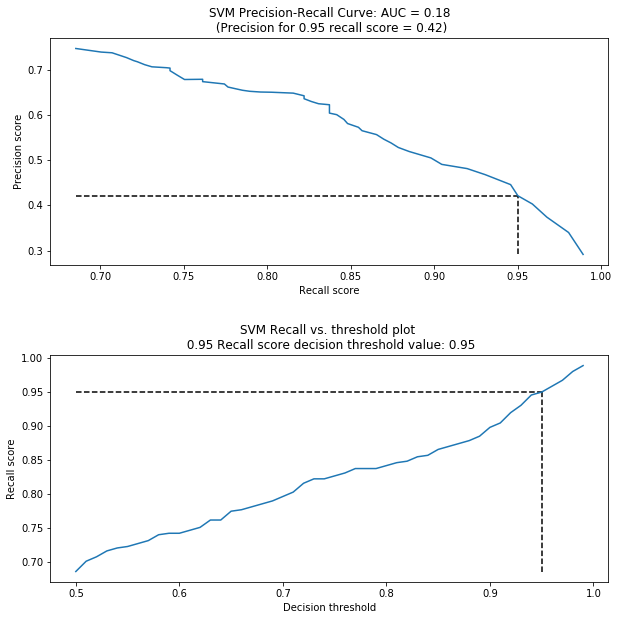

0.176023771283


In [13]:
model = 'SVM'
print(Result_plots(model, pred))

N


/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(1930, 28676)
(1930, 500)
[[ 460    1]
 [1266  203]]


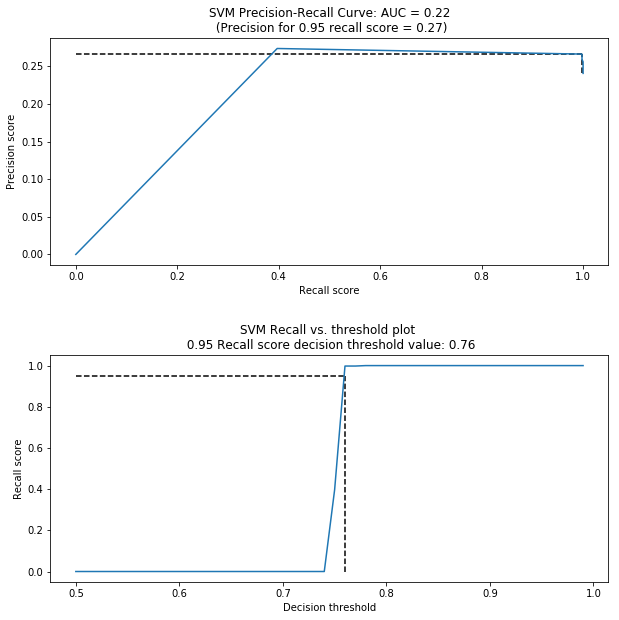

137.199849844
(1930, 28676)
(1930, 1000)
[[ 461    0]
 [1469    0]]


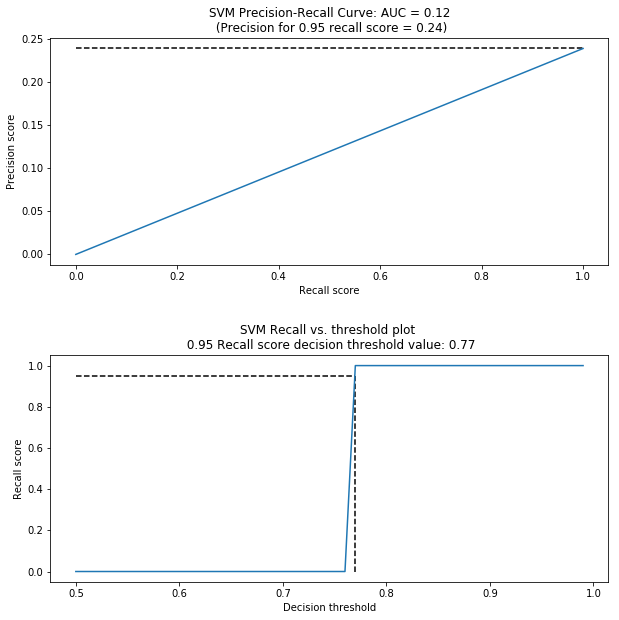

241.343481064
(1930, 28676)
(1930, 1500)
[[ 461    0]
 [1469    0]]


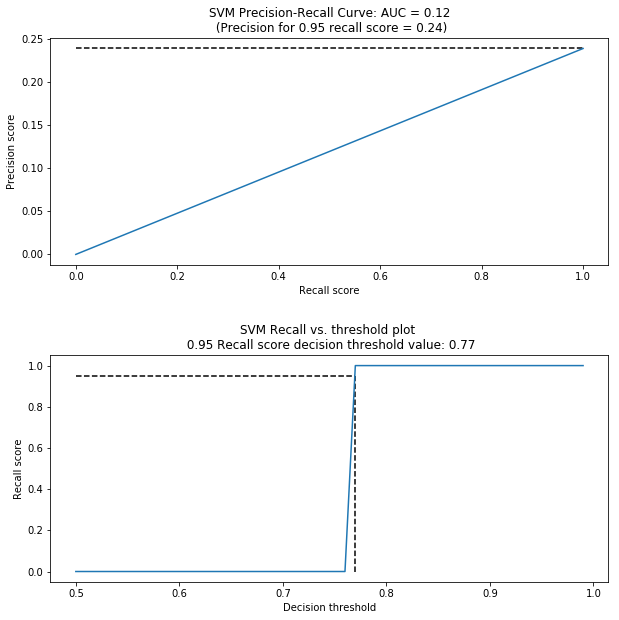

350.368366957
(1930, 28676)
(1930, 2000)
[[ 461    0]
 [1468    1]]


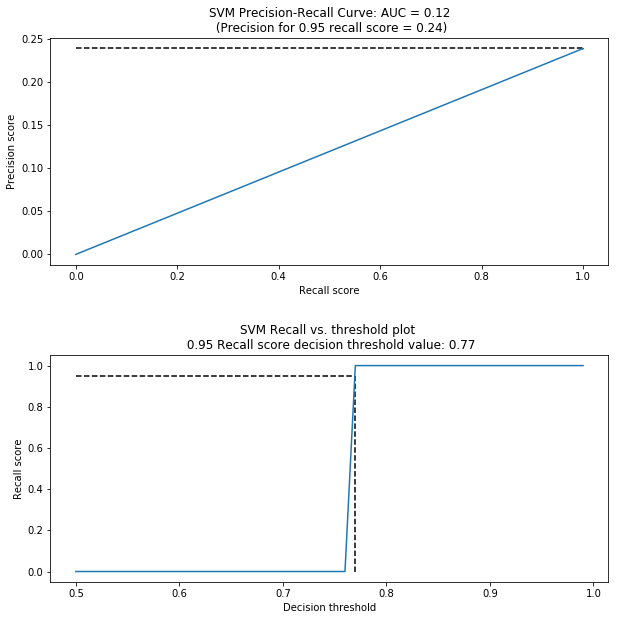

450.446372986
(1930, 28676)
(1930, 2500)
[[ 461    0]
 [1468    1]]


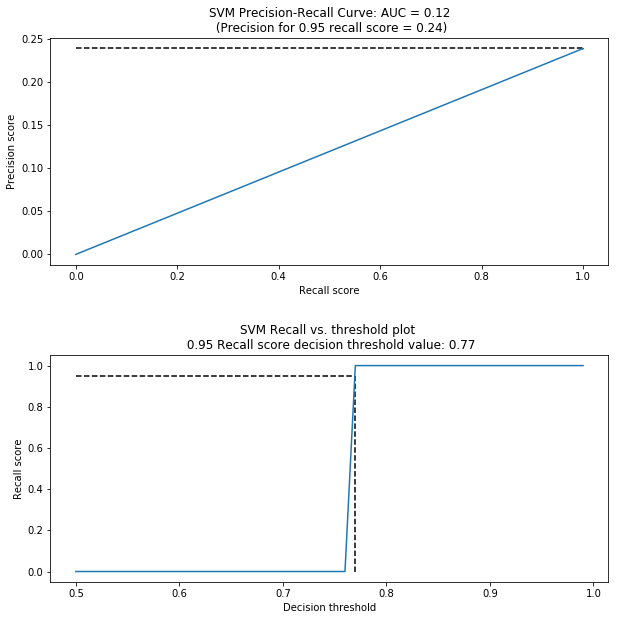

566.338054895
(1930, 28676)
(1930, 3000)
[[ 461    0]
 [1469    0]]


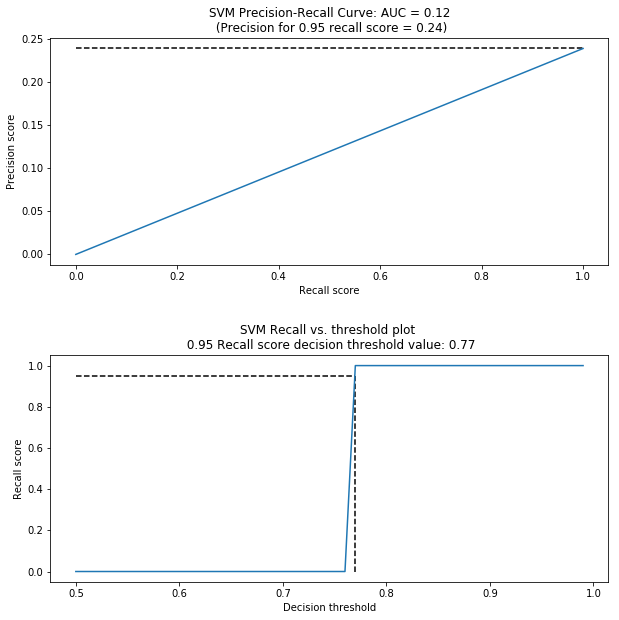

673.878220081
(1930, 28676)
(1930, 3500)


In [ ]:
#Feature set size and type optimisation
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
multiclass_model = False #Set to True if you want to build a multiclass classifier
normalised = False #Set to true if you want to normalise the feature vectore - Note that classifier trains faster
modelType = 'SVM' # NB - Naive bayes, SVM - support vector machine, Tree - Decision tree, 
#Gradient = Gradient boosting classifier, NN - Neural network, XG = XGBoost
feature_Selection = False #set to 'True' if you want to perform feature selection
ngram = (1,1) #tuple giving the range of ngrams considered
print(Data.loc[len(Data)-1, Label])
if multiclass_model == False: 
    for i in range(0, len(Data)-1):
        if Data.loc[i, Label] == 'RCT':
            Data.set_value(i, Label, 'Y')
        else: 
            Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])    
duplicates = Data.duplicated(['URL'])
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
SVM_RBF_AUC_list=[] #NB_AUC_list, NN_AUC_list, SVM_RBF_AUC_list, Tree_AUC_list, XGBoost_AUC_list, XG_AUC_list2, SVM_RBF_AUC_list2
MI_list = np.load('/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/uni_gram_MI_vector.npy')
for i in range(500, 10000, 500):
    start = time.time()
    feature_Vector = featureVector(Data, Abstract_heading, Title_heading, ngram)
    label_Vector = Data[Label].copy().as_matrix()
    feature_Vector = filtered_feature_vector(feature_Vector, i, MI_list)
    if modelType == 'SVM':
        clf = svm.SVC(kernel='rbf', C=10.0, gamma = 1.0, probability = True)
        model= 'SVM'
    if modelType == 'NB':
        clf = MultinomialNB()
        model='NB'
    if modelType == 'Tree':
        clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=210)
        model = 'Decision Tree'   
    if modelType == 'Gradient':
        clf = GradientBoostingClassifier()
        model = 'Gradient Boosting'
    if modelType == 'NN':
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,10), random_state = 1)
        model = 'Multi layer perceptron'
    if modelType == 'XG':
        clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators = 150, max_depth = 7)
        model = 'XGBoost'
    pred = cross_val_predict(clf, feature_Vector, label_Vector, cv=10, method='predict_proba')
    SVM_RBF_AUC_list.append(Result_plots(model, pred))
    end = time.time()
    print(end-start)

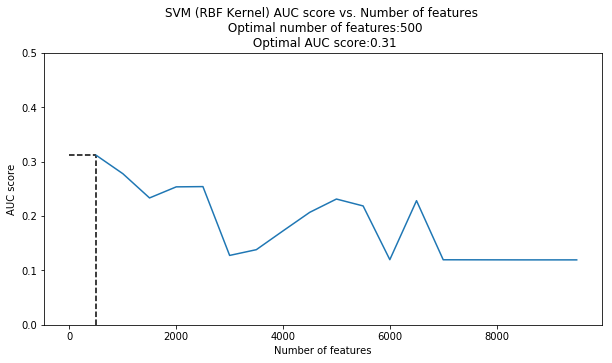

In [77]:
#feature size plots
feature_number_list = []
for i in range(500, 10000, 500):
    feature_number_list.append(i)
xline = feature_number_list[SVM_RBF_AUC_list2.index(max(SVM_RBF_AUC_list2))]
maximum = max(SVM_RBF_AUC_list2) 
plt.clf()
plt.figure(figsize=(10,5))
axes = plt.gca()
plt.hlines(y= maximum, xmin=0, xmax=xline, linestyles='dashed')
plt.vlines(x=xline, ymin=0, ymax=maximum, linestyles='dashed')
axes.set_ylim([0, 0.50])
plt.title('SVM (RBF Kernel) AUC score vs. Number of features \n Optimal number of features:' + str(xline) + '\n Optimal AUC score:{0:0.2f}'.format(maximum))
plt.ylabel('AUC score')
plt.xlabel('Number of features')
plt.plot(feature_number_list, SVM_RBF_AUC_list2)

plt.show()

N


/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


model fit complete


/Users/vishalpatel/anaconda3/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[[ 461    0]
 [1469    0]]


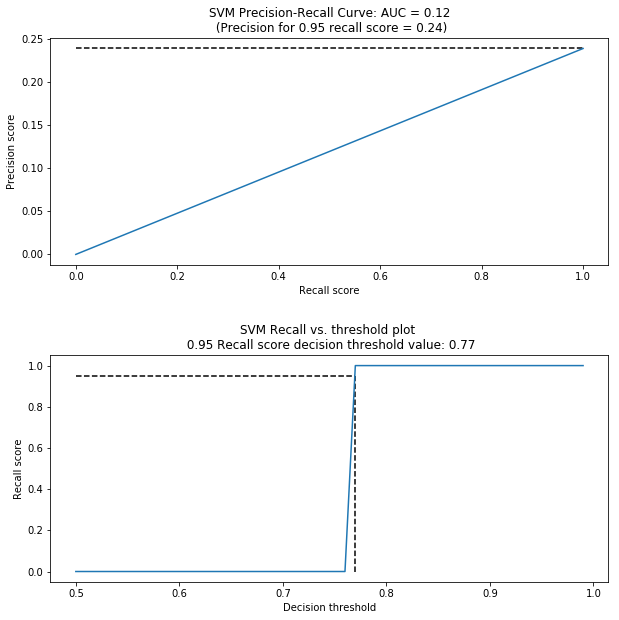

0.11943005181347151

In [7]:
#Validation models
file_loc = '/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/BaseCaseDataset.csv' #Insert file location
Data = pd.read_csv(file_loc, encoding='latin-1')
Label = 'Study type' #enter heading of column with labels
multiclass_model = False #Set to True if you want to build a multiclass classifier
normalised = False #Set to true if you want to normalise the feature vectore - Note that classifier trains faster
modelType = 'SVM' # NB - Naive bayes, SVM - support vector machine, Tree - Decision tree, 
#Gradient = Gradient boosting classifier, NN - Neural network, XG = XGBoost
feature_Selection = False #set to 'True' if you want to perform feature selection
ngram = (1,1) #tuple giving the range of ngrams considered
print(Data.loc[len(Data)-1, Label])
if multiclass_model == False: 
    for i in range(0, len(Data)-1):
        if Data.loc[i, Label] == 'RCT':
            Data.set_value(i, Label, 'Y')
        else: 
            Data.set_value(i, Label, 'N')
Data = Data.drop_duplicates(['URL'])    
duplicates = Data.duplicated(['URL'])
Abstract_heading = 'Abstract' #enter heading of column with abstract
Title_heading = 'Title'
feature_Vector = featureVector(Data, Abstract_heading, Title_heading, ngram)
label_Vector = Data[Label].copy().as_matrix()
if normalised: 
    feature_Vector = normalisedFeatureVector(feature_Vector, label_Vector)
if feature_Selection == True:
#     MI_list = mutual_info_classif(feature_Vector, label_Vector)
    feature_Vector = filtered_feature_vector(feature_Vector, 5000, MI_list)
Tree_AUC_List_Validate=[] #NB_AUC_List_Validate, Tree_AUC_List_Validate
# MI_list = np.load('/Volumes/Toshiba/DataScienceMasters/ResearchProject/BaseCaseAnalysis/bi_gram_MI_vector.npy')

if modelType == 'SVM':
    clf = svm.SVC(kernel='rbf', C=10.0, gamma = 1.0, probability = True)
    model= 'SVM'
if modelType == 'NB':
    clf = MultinomialNB()
    model='NB'
if modelType == 'Tree':
    clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=210)
    model = 'Decision Tree'   
if modelType == 'Gradient':
    clf = GradientBoostingClassifier()
    model = 'Gradient Boosting'
if modelType == 'NN':
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,10), random_state = 1)
    model = 'Multi layer perceptron'
if modelType == 'XG':
    clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators = 150, max_depth = 7)
    model = 'XGBoost'

feat_sel = SelectKBest(mutual_info_classif, k=1500) #set k=optimal feature set size for model type
pipe = Pipeline([('mutual_info', feat_sel), (model, clf)])
pred = cross_val_predict(pipe, feature_Vector, label_Vector, cv=10, method='predict_proba')
print('model fit complete')
Result_plots(model, pred)